#Demo model


In [1]:
import numpy as np
from PIL import Image
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [2]:
file_path = r"/content/pneumoniamnist - Copy.npz"

In [3]:
data=np.load(file_path)

In [4]:
print(data.files)

['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


In [5]:
print("Train images shape:", data['train_images'].shape)
print("Validation images shape:", data['val_images'].shape)
print("Test images shape:", data['test_images'].shape)

Train images shape: (3882, 28, 28)
Validation images shape: (524, 28, 28)
Test images shape: (624, 28, 28)


In [6]:
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [7]:
data = np.load(file_path)
X_train = data['train_images']
y_train = data['train_labels']
X_val = data['val_images']
y_val = data['val_labels']
X_test = data['test_images']
y_test = data['test_labels']

# Normalize images (if they are 0–255 pixel values)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [8]:
# One-hot encode labels if classification
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Build simple model
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8994 - loss: 0.3562 - val_accuracy: 0.8721 - val_loss: 0.2898
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9369 - loss: 0.1699 - val_accuracy: 0.8378 - val_loss: 0.3634
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9485 - loss: 0.1390 - val_accuracy: 0.9466 - val_loss: 0.1719
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9514 - loss: 0.1219 - val_accuracy: 0.8053 - val_loss: 0.5130
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9479 - loss: 0.1411 - val_accuracy: 0.9046 - val_loss: 0.2106
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9571 - loss: 0.1168 - val_accuracy: 0.9485 - val_loss: 0.1465
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9628 - loss: 0.1027 - val_accuracy: 0.9523 - val_loss: 0.1487
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9627 - loss: 0.0922 - val_accuracy: 0.9294 - val_

In [9]:
# Access images and labels
images = data['train_images']
labels = data['train_labels']


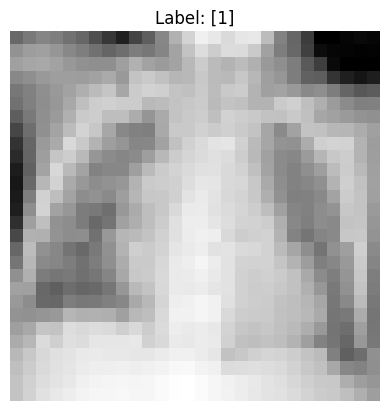

In [10]:
plt.imshow(images[0], cmap='gray')  # Use cmap='gray' if grayscale
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

# Resnet50 begins


In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import Sequence

In [2]:
file_path = r"/content/pneumoniamnist - Copy.npz"

In [3]:
data = np.load(file_path)
X_train = data['train_images']
y_train = data['train_labels']
X_val = data['val_images']
y_val = data['val_labels']
X_test = data['test_images']
y_test = data['test_labels']

In [4]:
print("Original shape:", X_train.shape)

Original shape: (3882, 28, 28)


In [5]:
num_classes = len(np.unique(y_train))

In [6]:
# Create a generator to handle memory-efficient image resizing & batching
class ImageGenerator(Sequence):
    def __init__(self, images, labels, batch_size, num_classes, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = [self.images[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        resized_images = []
        for img in batch_images:
            # Resize to 224x224
            img_resized = cv2.resize(img, (224, 224))
            # Convert grayscale to 3 channels
            if img_resized.ndim == 2:
                img_resized = np.stack([img_resized]*3, axis=-1)
            resized_images.append(img_resized)

        resized_images = np.array(resized_images, dtype=np.float32) / 255.0
        batch_labels = tf.keras.utils.to_categorical(batch_labels, self.num_classes)

        return resized_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [7]:
# Create generators
batch_size = 32
train_gen = ImageGenerator(X_train, y_train, batch_size, num_classes)
val_gen = ImageGenerator(X_val, y_val, batch_size, num_classes)
test_gen = ImageGenerator(X_test, y_test, batch_size, num_classes, shuffle=False)


In [8]:
# Define the ResNet50 model
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=output_tensor)

In [11]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_gen,
          validation_data=val_gen,
          epochs=10)

# Evaluate on test data
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


122/122 ━━━━━━━━━━━━━━━━━━━━ 796s 6s/step - accuracy: 0.9077 - loss: 0.3476 - val_accuracy: 0.7424 - val_loss: 0.5797
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 770s 6s/step - accuracy: 0.8949 - loss: 0.3385 - val_accuracy: 0.7424 - val_loss: 0.7208
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 771s 6s/step - accuracy: 0.9005 - loss: 0.3251 - val_accuracy: 0.7424 - val_loss: 0.6462
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 765s 6s/step - accuracy: 0.9066 - loss: 0.3092 - val_accuracy: 0.7424 - val_loss: 0.6141
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 812s 7s/step - accuracy: 0.9069 - loss: 0.3038 - val_accuracy: 0.7424 - val_loss: 0.6514
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 849s 7s/step - accuracy: 0.9057 - loss: 0.2994 - val_accuracy: 0.7424 - val_loss: 0.5350
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 811s 7s/step - accuracy: 0.8977 - loss: 0.3193 - val_accuracy: 0.7424 - val_loss: 0.7702
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 762s 6s/step - accuracy: 0.9049 - loss: 0.2992 - val_accuracy: 0.742

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


121/122 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


122/122 ━━━━━━━━━━━━━━━━━━━━ 700s 6s/step
🔍 Confusion Matrix for Training Set:
[[   1  387]
 [   0 3494]]


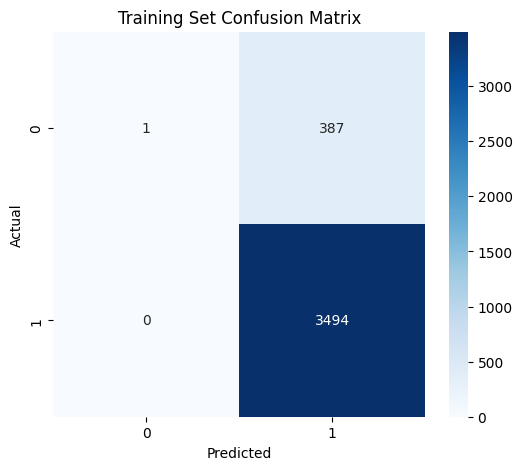

✅ Training Set Accuracy: 0.9003
✅ Training Set Cohen’s Kappa: 0.0046
✅ Training Set F1 Score: 0.8533

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       388
           1       0.90      1.00      0.95      3494

    accuracy                           0.90      3882
   macro avg       0.95      0.50      0.48      3882
weighted avg       0.91      0.90      0.85      3882

17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step
🔍 Confusion Matrix for Validation Set:
[[  0 135]
 [  0 389]]


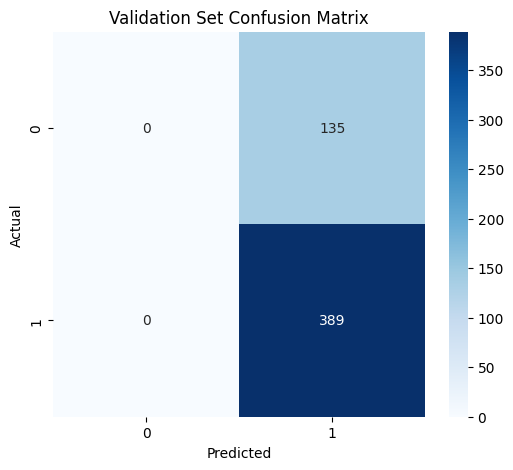

✅ Validation Set Accuracy: 0.7424
✅ Validation Set Cohen’s Kappa: 0.0000
✅ Validation Set F1 Score: 0.6326

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.74      1.00      0.85       389

    accuracy                           0.74       524
   macro avg       0.37      0.50      0.43       524
weighted avg       0.55      0.74      0.63       524



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step
🔍 Confusion Matrix for Test Set:
[[  0 234]
 [  0 390]]


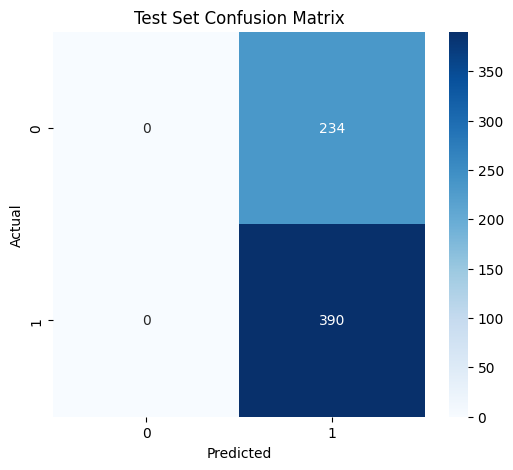

✅ Test Set Accuracy: 0.6250
✅ Test Set Cohen’s Kappa: 0.0000
✅ Test Set F1 Score: 0.4808

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(name, generator, y_true):
    # Get predictions
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.array(y_true)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"🔍 Confusion Matrix for {name}:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')  # weighted for multi-class
    print(f"✅ {name} Accuracy: {accuracy:.4f}")
    print(f"✅ {name} Cohen’s Kappa: {kappa:.4f}")
    print(f"✅ {name} F1 Score: {f1:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate on training set
evaluate_model("Training Set", train_gen, y_train)

# Evaluate on validation set
evaluate_model("Validation Set", val_gen, y_val)

# Evaluate on test set
evaluate_model("Test Set", test_gen, y_test)
